In [1]:
## imports

# nd array manipulation
import numpy as np

# plotting with matplotlib, notebook with jplot style
%matplotlib notebook
import matplotlib.pyplot as plt
from jupyterthemes import jtplot; jtplot.style()

# 3d plotting toolkit
from mpl_toolkits.mplot3d import Axes3D

# colour mapping helpers
import matplotlib.colors as colors
import matplotlib.cm as cmx


In [2]:

def get_intercept(C, r, e, L0, v):
    ## calculate intersection line and ellipsoid

    # ellipse centre, radius, and axis vectors
    C = np.array([C]).T

    # point on line (origin) and direction vector
    L0 = np.array([L0]).T
    v = np.array([v]).T

    # Translation Matrix
    T = np.identity(4)
    T[:-1,-1:] = C

    
    #### fix rotation if required in future
    
    # Rotation/Scale Matrix ?
    R = np.identity(4)
    R[:-1,:-1] = np.identity(3) * np.array(e).T

    a = np.array([[1., 0., 0.]]).T# * e[0]
    b = np.array([[0., 1., 0.]]).T# * e[1]
    c = np.array([[0., 0., 1.]]).T# * e[2]
    
    # Scale/Rotate Matrix ?
    #S = np.identity(4)
    #S[0,0] = np.linalg.norm(a)
    #S[1,1] = np.linalg.norm(b)
    #S[2,2] = np.linalg.norm(c)

    # Transformation Matrix
    M = T @ R #@ S

    
    # rescaled sphere centre
    C_ = np.array([[0, 0, 0, 1]]).T

    # transformed line origin
    L0_ = np.linalg.inv(M) @ np.row_stack([L0,[1]])
    # difference line vector
    w = L0_ - C_

    # transformed line vector
    v_ = np.linalg.inv(M) @ np.row_stack([v,[0]])

    # coefficients of quadratic intersection
    a_ = (v_.T @ v_)[0]
    b_ = 2*((v_.T @ w)[0])
    c_ = (w.T @ w)[0] - r**2

    # descriminant of quadratic
    d_ = b_**2 - 4*a_*c_

    # intersection points
    if d_ > 0:
        t1 = (-b_ + np.sqrt(d_)) / (2*a_)
        t2 = (-b_ - np.sqrt(d_)) / (2*a_)
        L_int1 = L0 + t1 * v
        L_int2 = L0 + t2 * v
        icept = [L_int1, L_int2]

    # tangent intercept
    elif d_ == 0:
        t = -b_ / (2*a_)
        L_int = L0 + t * v
        icept = [L_int]

    # no intercept
    else:
        icept = []

    # return intercepts
    return icept


In [3]:

def get_surface_normal(C, e, p):

    # calculate normal vector using coefficients of equation of plane at intercept point
    #(x*x0/a**2) + (y*y0/b**2) + (z*z0/c**2) = r
    n = (p-C) / e**2
    # normalise to unit vector
    n = n / np.linalg.norm(n)
    
    # return surface normal
    return n


In [4]:

def get_refracted_vector(n1, n2, N, v):
    
    # calculate vector of refraction using incident vector and surface normal
    V = (n1/n2) * np.cross(N, np.cross(-N, v)) - N * np.sqrt(1 - ((n1/n2)**2) * (np.cross(N, v) @ np.cross(N, v)))
    
    return V


<IPython.core.display.Javascript object>


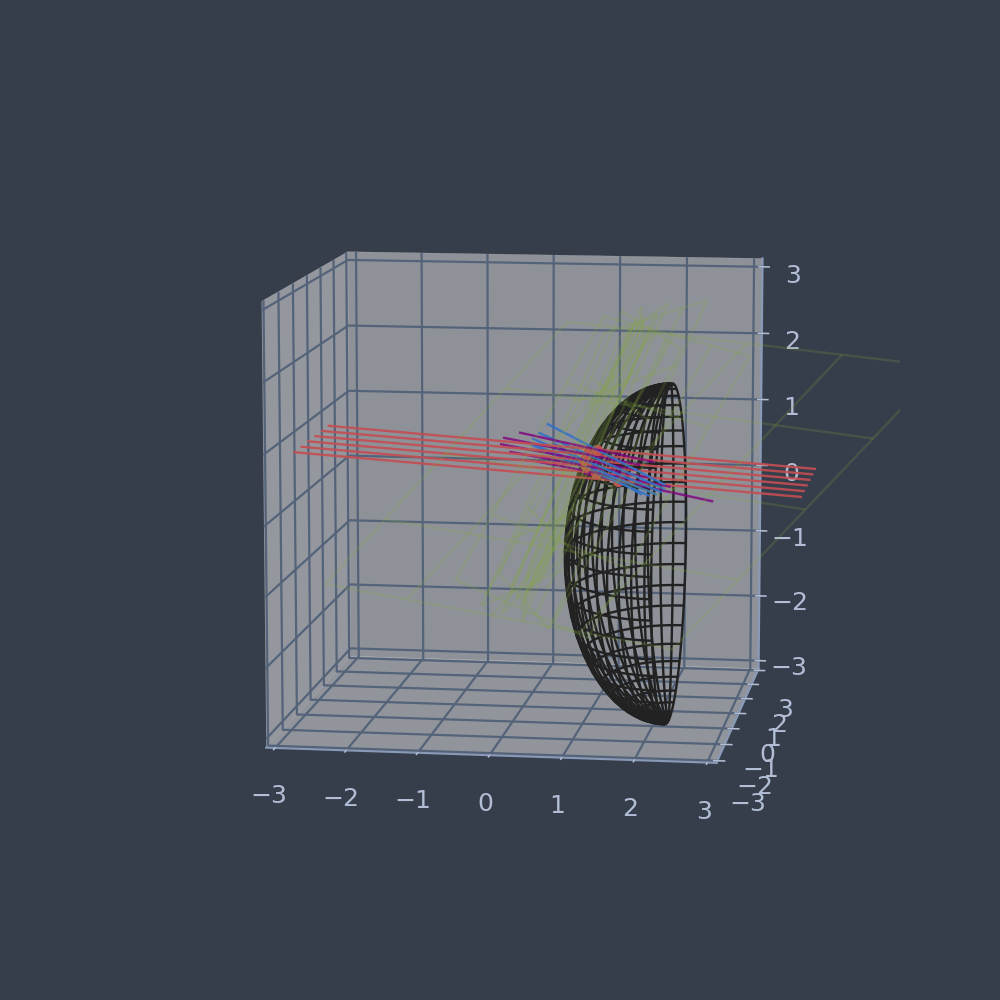

In [5]:

# initialise 3d figure
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim(-3., 3.)
ax.set_ylim(-3., 3.)
ax.set_zlim(-3., 3.)


# ellipse centre, radius, and axis vectors
C = np.array([2., 1., -1.])
r = 2.5
#e = [0.4, .6, .6]
e = np.array([0.6, .9, 1.])

rx, ry, rz = np.array(e) * r

# Set of all spherical angles:
u = np.linspace(0.5 * np.pi, 1.5 * np.pi, 50)
k = np.linspace(0., np.pi, 50)

# Cartesian coordinates that correspond to the spherical angles:
# (this is the equation of an ellipsoid):
x = rx * np.outer(np.cos(u), np.sin(k)) + C[0]
y = ry * np.outer(np.sin(u), np.sin(k)) + C[1]
z = rz * np.outer(np.ones_like(u), np.cos(k)) + C[2]

# plot ellipsoid
ax.plot_wireframe(x, y, z,  rstride = 2, cstride = 2, color = 'k')


for Ly in np.arange(-1., 2., .5)[:]:

    # point on line (origin) and direction vector
    #L0 = [.0, 2., .5]
    L0 = [.0, Ly, .5]
    v = [1., .2, -.1]

    icepts = get_intercept(C, r, e, L0, v)

    # define ray line points
    line = np.array([L0]).T + np.arange(-3., 5., 1.) * np.array([v]).T

    # plot ray line from points
    ax.plot( line[0,], line[1,], line[2,], color = 'r', alpha = 0.9)

    # plot intercept points
    for icept in icepts[-1:]:
        ax.plot(*icept, 'or')

    # point of intercept (on tangent plane)
    p = icepts[-1][:,0]

    # calculate surface normal vector
    n = get_surface_normal(C, e, p)

    # calculate d coefficient from point and normal vector
    d = p @ n - r

    # define ray line points
    line = np.array([p]).T + np.arange(p[0] - 2., p[0] + 1.) * np.array([n]).T
    # plot ray line from points
    ax.plot( line[0,], line[1,], line[2,], color = 'b', alpha = 0.9)


    # create y,z mesh
    yy, zz = np.meshgrid(np.arange(p[1] - 2., p[1] + 3.), np.arange(p[2] - 2., p[2] + 3.))
    # calculate corresponding x
    x = (r - (yy*n[1]) - (zz*n[2]) + d) / n[0]

    # plot ellipsoid
    ax.plot_wireframe(x, yy, zz,  rstride = 1, cstride = 1, color = 'g', alpha = 0.2)

    
    n1 = 1.0
    n2 = 1.5
    
    V = get_refracted_vector(n1, n2, n, v)

    # define ray line points
    line = np.array([p]).T + np.arange(p[0] - 2., p[0] + 1.) * np.array([V]).T
    # plot ray line from points
    ax.plot( line[0,], line[1,], line[2,], color = 'purple', alpha = 0.8)
    

# format and display figure
plt.show()


<IPython.core.display.Javascript object>


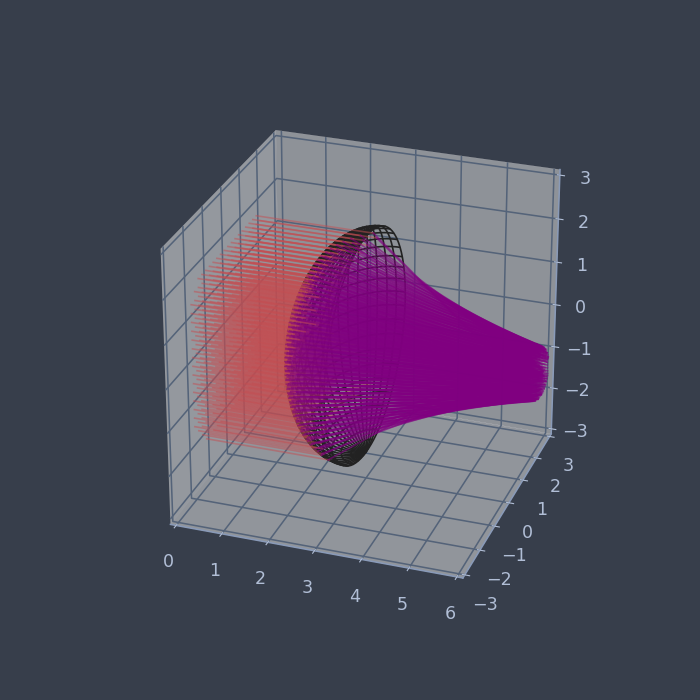

In [6]:

# initialise 3d figure
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim(0., 6.)
ax.set_ylim(-3., 3.)
ax.set_zlim(-3., 3.)

# initial refractive index
n1 = 1.0

# ellipse centre, radius, and axis vectors
C = np.array([3., 0., 0.])
r = 2.5
#e = [0.4, .6, .6]
e = np.array([0.6, 1., 1.])
# optic refractive index
n2 = 1.8

# generate and plot lens
rx, ry, rz = np.array(e) * r
# set of all spherical angles:
u = np.linspace(0.5 * np.pi, 1.5 * np.pi, 50)
k = np.linspace(0., np.pi, 50)
# Cartesian coordinates that correspond to the spherical angles:
# (this is the equation of an ellipsoid):
x = rx * np.outer(np.cos(u), np.sin(k)) + C[0]
y = ry * np.outer(np.sin(u), np.sin(k)) + C[1]
z = rz * np.outer(np.ones_like(u), np.cos(k)) + C[2]
# plot ellipsoid
ax.plot_wireframe(x, y, z,  rstride = 2, cstride = 2, color = 'k')


for Lz in np.arange(-2., 2.0, .2)[:]:
    for Ly in np.arange(-2., 2.0, .2)[:]:

        # point on line (origin) and direction vector
        L0 = [0., Ly, Lz]
        v = [1., 0., 0.]
        v = v / np.linalg.norm(v)

        # calculate ray ellipsoid intersection
        icepts = get_intercept(C, r, e, L0, v)

        # only calculate refraction for intersections (exclude tangents)
        if len(icepts) > 1:
            # point of intercept (on surface normal)
            p = icepts[-1][:,0]

            # define ray line points and plot
            line = np.array([L0]).T + np.arange(0., p[0] + .1, .1) * np.array([v]).T
            ax.plot( line[0,], line[1,], line[2,], color = 'r', alpha = 0.5)
            
            # calculate surface normal vector
            n = get_surface_normal(C, e, p)

            # get unit vector of refracted ray using snells law
            V = get_refracted_vector(n1, n2, n, v)

            # define ray line points
            line = np.array([p]).T + np.arange(0, 2*r, .1) * np.array([V]).T
            # plot ray line from points
            ax.plot( line[0,], line[1,], line[2,], color = 'purple', alpha = 0.6)
    

# format and display figure
plt.show()


In [23]:

def plot_3d_ellipsoid(C, r, e, ax, rev):
    
    # generate and plot lens
    rx, ry, rz = np.array(e) * r
    # set of all spherical angles:
    #u = np.linspace(0.5 * np.pi, 1.5 * np.pi, 50)
    if rev:
        u = np.linspace(1.5 * np.pi, 2.5 * np.pi, 50)
    else:
        u = np.linspace(0.5 * np.pi, 1.5 * np.pi, 50)
    k = np.linspace(0., np.pi, 50)
    # Cartesian coordinates that correspond to the spherical angles:
    # (this is the equation of an ellipsoid):
    x = rx * np.outer(np.cos(u), np.sin(k)) + C[0]
    y = ry * np.outer(np.sin(u), np.sin(k)) + C[1]
    z = rz * np.outer(np.ones_like(u), np.cos(k)) + C[2]
    # plot ellipsoid
    ax.plot_wireframe(x, y, z,  rstride = 2, cstride = 2, color = 'k', alpha = 0.5)

    
def plot_3d_line(o, v, xl):
    
    # define ray line points and plot
    line = np.array([o]).T + np.arange(0., xl + .1, .1) * np.array([v]).T
    ax.plot( line[0,], line[1,], line[2,], color = 'y', alpha = 0.7)
    #ax.plot( line[0,], line[1,], line[2,], alpha = 0.7)


<IPython.core.display.Javascript object>


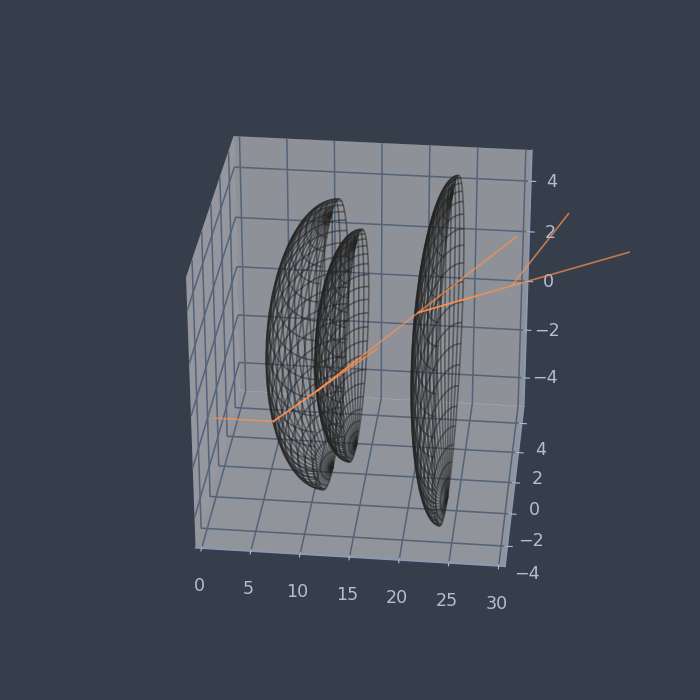

In [17]:

# define optics
## update centre position to relative front surface of optic

optics = [
    {
        'centre': np.array([5.+5*1.3, 0., 0.]),
        'opt_den': 1.5,
        'scale': np.array([1.3, 1., 1.]),
        'radius': 5.,
        'rev': False,
    },
    {
        'centre': np.array([10.+4., 0., 0.]),
        'opt_den': 1.8,
        'scale': np.array([1., 1., 1.]),
        'radius': 4.,
        'rev': False,
    },
    {
        'centre': np.array([20.+6.*0.6, 0., 0.]),
        'opt_den': 3.0,
        'scale': np.array([0.6, 1., 1.]),
        'radius': 6.0,
        'rev': False,
    },
    {
        'centre': np.array([30., 0., 0.]),
        'opt_den': 1.0,
        'scale': np.array([0.1, 1., 1.]),
        'radius': 6.0,
        'rev': False,
    },
    
]


# initialise 3d figure
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim(0., 30.)
ax.set_ylim(-5., 5.)
ax.set_zlim(-5., 5.)

# plot all optics
for optic in optics[:-1]:
    # define optic(ellipsoid): centre, radius, axes scale, refractive index
    C = optic['centre']
    r = optic['radius']
    e = optic['scale']
    n2 = optic['opt_den']
    rev = optic['rev']
    # plot optic
    plot_3d_ellipsoid(C, r, e, ax, rev)


## ray tracing
stp = 1.
rng = 2.
for Lz in np.arange(-rng, rng + stp, stp)[:1]:
    for Ly in np.arange(-rng, rng + stp, stp)[:1]:
        
        # initial refractive index (air)
        n1 = 1.0
        # origin ray position and direction vector
        L0 = [0., Ly, Lz]
        v = [1., 0., 0.]#; v = v / np.linalg.norm(v)

        for optic in optics:
            # define optic(ellipsoid): centre, radius, axes scale, refractive index
            C = optic['centre']
            r = optic['radius']
            e = optic['scale']
            n2 = optic['opt_den']

            
            # calculate ray ellipsoid intersection
            icepts = get_intercept(C, r, e, L0, v)
            # only calculate refraction for intersections (exclude tangents)
            if len(icepts) > 1:
                # point of intercept (on surface normal)
                p = icepts[-1][:,0]

                # plot origin ray to optic intercept
                plot_3d_line(L0, v, p[0])


                # calculate surface normal vector
                n = get_surface_normal(C, e, p)
                # get unit vector of refracted ray using snells law
                V = get_refracted_vector(n1, n2, n, v)

                # plot refracted ray through optic intercept
                plot_3d_line(p, V, r)


                # update origin ray position and vector
                n1 = n2
                v = V
                L0 = p


# format and display figure
plt.show()


In [ ]:
## store points for initial and each intercept with direction unit vector

# build array of initial ray locations with direction vectors

# define optics in path

# calculate full path of each individual ray through optics chain, save path details

## finally plot optics and rays for display, use ray path details to build 

In [113]:

def refraction(C, r, e, L0, v, n1, n2, rev):
    
    # calculate ray ellipsoid intersection
    icepts = get_intercept(C, r, e, L0, v)
    
    # only calculate refraction for intersections (exclude tangents)
    if len(icepts) > 1:
        
        points = []
        
        for icept in icepts:
        # point of intercept (on surface normal)
            p = icept[:,0]

            # calculate surface normal vector
            n = get_surface_normal(C, e, p)
            
            if rev:
                n = -n
            
            # get unit vector of refracted ray using snells law
            V = get_refracted_vector(n1, n2, n, v)
            
            points.append([p, V])
    
        # return intercept point and refraction ray direction vector
        return points
    
    return None


In [114]:

def get_paths(rays, optics):

    paths = []

    # iterate over rays
    for i in range(len(rays)):

        # initial refractive index (air)
        n1 = 1.0
        # origin ray position and direction vector
        L0 = rays[i][0]
        v = rays[i][1]

        path = []    
        # store initial ray path details
        path.append([L0, v])

        # iterate over optics in path
        for optic in optics:
            # optic(ellipsoid): centre, radius, axes scale, refractive index
            C = optic['centre']
            r = optic['radius']
            e = optic['scale']
            n2 = optic['opt_den']
            rev = optic['rev']

            # for intercept ray with optic, get new refracted ray
            ray = refraction(C, r, e, L0, v, n1, n2, rev)

            # if refracted ray, unpack
            if ray is not None:

                # check which side intersection is wanted
                if rev:
                    p, V = ray[0]
                else:
                    p, V = ray[1]

                # store ray path details
                path.append([p, V])

                # update new ray start
                n1 = n2
                v = V
                L0 = p

            else:
                break

        # store ray path
        paths.append(path)
        
    return paths


In [ ]:
# define optics
## update centre position to relative front surface of optic

# define from previous optic
dx = 10.
# radius of optic
r = 1.377
# x direction asphericity
asph = 




In [206]:
optics = [
    { # cornea
        'centre': np.array([(10. + 7.8*np.sqrt(0.5)), 0., 0.]),
        'opt_den': 1.377,
        'scale': np.array([np.sqrt(0.5), 1., 1.]), # conic constant of -0.5
        'radius': 7.8,
        'rev': False,
    },
    { # aqueous
        'centre': np.array([(10.6 + 6.4), 0., 0.]),
        'opt_den': 1.336,
        'scale': np.array([1., 1., 1.]),
        'radius': 6.4,
        'rev': False,
    },
    { # iris
        'centre': np.array([(13.5 + 2.0 * 0.01), 0., 0.]),
        'opt_den': 1.336,
        'scale': np.array([0.01, 1., 1.]),
        'radius': 2.0,
        'rev': False,
    },
    { # lens front
        'centre': np.array([(13.6 + 10.1), 0., 0.]),
        #'centre': np.array([(13.6 + 5.95), 0., 0.]),
        'opt_den': 1.411,
        'scale': np.array([1., 1., 1.]),
        'radius': 10.1, # 10.1 at inf., 5.95 near
        #'radius': 5.95, # 10.1 at inf., 5.95 near
        'rev': False,
    },
    { # lens rear
        'centre': np.array([(17.6 - 6.1*np.sqrt(4.5)), 0., 0.]),
        'opt_den': 1.337,
        #'opt_den': 1.411,
        'scale': np.array([np.sqrt(4.5), 1., 1.]),
        'radius': 6.1,
        'rev': True,
    },
    { # retina
        'centre': np.array([34.8 + 12.5, 0., 0.]),
        'opt_den': 1.,
        'scale': np.array([1., 1., 1.]),
        'radius': 12.5,
        'rev': True,
    },
    
]

In [242]:
rays = []

## ray tracing
stp = .02
rng = 1.
for Lz in np.arange(-rng, rng + stp, stp)[:]:
    for Ly in np.arange(-rng, rng + stp, stp)[:]:
        
        # origin ray position and direction vector
        L0 = np.array([0., Ly, Lz])
        v = np.array([1., 0., 0.])
        # normalise direction vector to unit
        v = v / np.linalg.norm(v)
        
        rays.append([L0, v])


In [243]:

paths = get_paths(rays, optics)


<IPython.core.display.Javascript object>


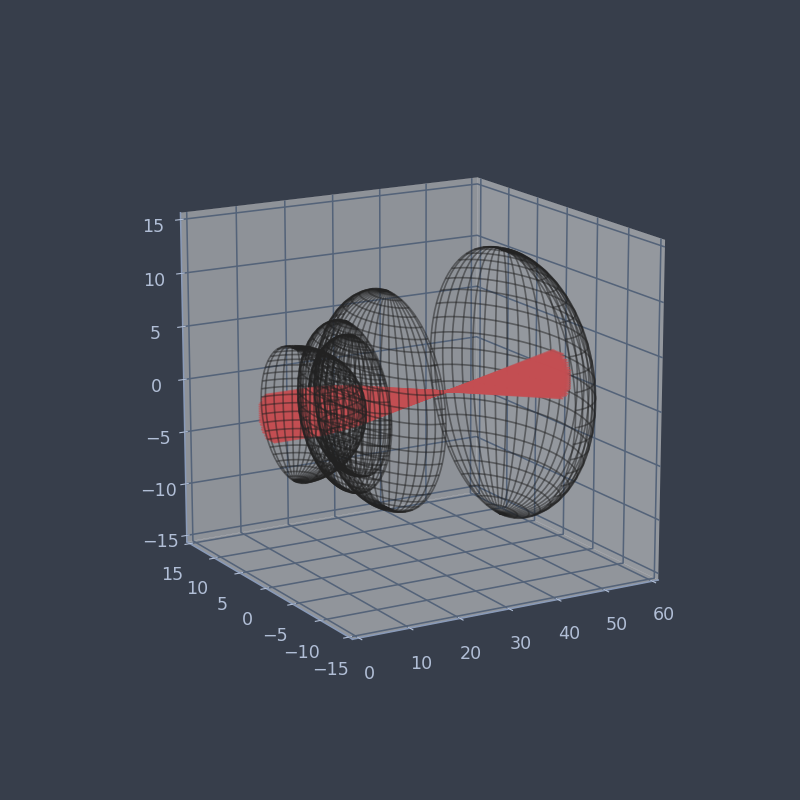

In [212]:
## plot ray paths

# initialise 3d figure
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim(0., 60.)
ax.set_ylim(-15., 15.)
ax.set_zlim(-15., 15.)


# plot all optics
if True:
    for optic in optics[:]:
        # define optic(ellipsoid): centre, radius, axes scale, refractive index
        C = optic['centre']
        r = optic['radius']
        e = optic['scale']
        n2 = optic['opt_den']
        rev = optic['rev']
        # plot optic
        plot_3d_ellipsoid(C, r, e, ax, rev)


for i in range(len(paths)):
    
    # check for any refraction of ray with optics
    #if len(paths[i]) > 1:
    # only ray that hit retina
    if len(paths[i]) == 7:
        path = paths[i]
        
        # iterate ray path through optics
        for j in range(len(path)-1):
            
            # plot path segment
            ax.plot([path[j][0][0], path[j+1][0][0]],
                    [path[j][0][1], path[j+1][0][1]],
                    [path[j][0][2], path[j+1][0][2]],
                    color = 'r', alpha = 0.7)

# format and display figure
plt.show()


In [234]:

def get_retinal_img(paths, r, d):
    
    # get retinal image
    r_img = np.stack([ path[-1][0] for path in paths ])

    # get index of rays that reach retina, filter
    j = [ i for i in range(len(paths)) if len(paths[i]) == 7 ]
    r_img = r_img[j]

    # calculate stereographic projection onto 2d plane from 3d retinal image
    z = r_img[:,0] - d - r
    x = ( r_img[:,1] / (0.5 - z) ) * r
    y = ( r_img[:,2] / (0.5 - z) ) * r

    return np.stack([x, y]).T


<IPython.core.display.Javascript object>


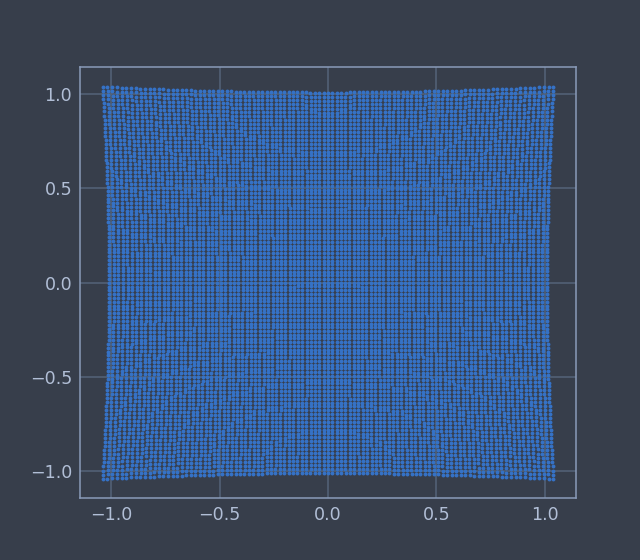

In [302]:

# retinal distance and radius
r = 12.5
d = 34.8
# get retinal image
img = get_retinal_img(paths, r, d)

# plot 2d retinal image
plt.plot(img[:,0], img[:,1], '.b')

plt.show()


<IPython.core.display.Javascript object>


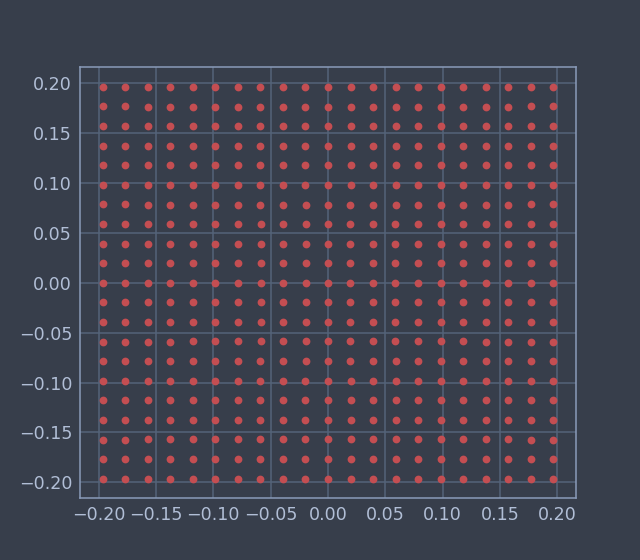

In [247]:

## focus fovea

# retinal distance and radius
r = 12.5
d = 34.8
# get retinal image
img = get_retinal_img(paths, r, d)
# trim range for fovea region
fr = 0.2
j = np.where((np.abs(img[:,0]) <= fr ) & (np.abs(img[:,1]) <= fr ))
x = img[j,0]
y = img[j,1]

# plot 2d retinal image
plt.plot(x, y, 'or')

plt.show()


In [250]:

# image import, processing, export
import PIL
# image manipulation
from scipy import ndimage


<IPython.core.display.Javascript object>


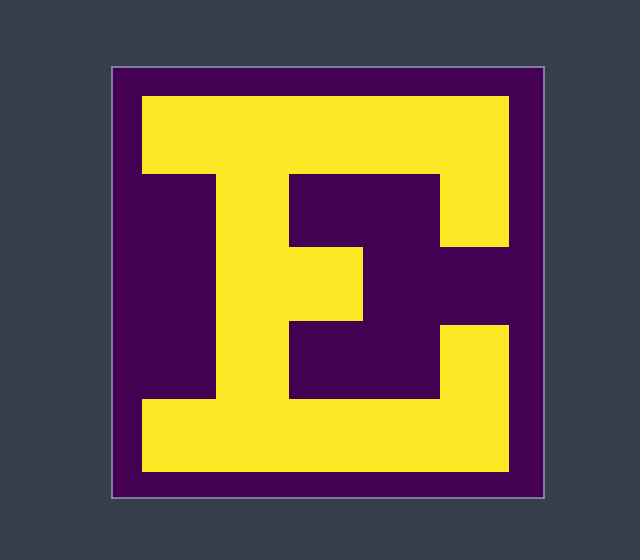

In [297]:
# import image data from tif file into np array
test_image = np.array( PIL.Image.open('./test-img-1.png') )

plt.imshow(image)
plt.grid(); plt.xticks([]); plt.yticks([])
plt.show()

<IPython.core.display.Javascript object>


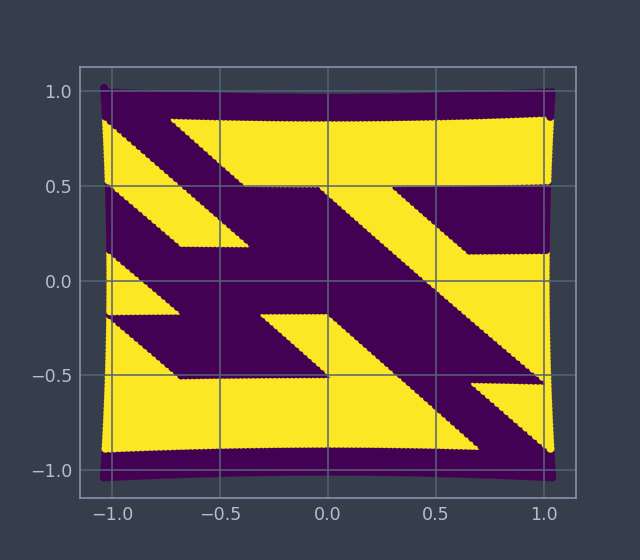

In [314]:

# retinal distance and radius
r = 12.5
d = 34.8
# get retinal image
img = get_retinal_img(paths, r, d)[:10000,:]

t_map = np.array([test_image.flatten()[:10000]]).T

img = np.column_stack([img, t_map])

plt.scatter(img[:,0], img[:,1], c = img[:,2])

plt.show()
